In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score, precision_score, recall_score
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from tqdm import tqdm
from PIL import Image, ImageDraw
import cv2
import os

# Try to fix sympy compatibility issue
# Some internal torch operations (like those in _dynamo) rely on sympy.
# An AttributeError often means sympy is an incompatible version or corrupted.
!pip install --upgrade sympy --quiet

# Set device and random seeds for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

print(f"Using device: {device}")
scaler = torch.cuda.amp.GradScaler()

Using device: cuda


/tmp/ipython-input-1681581120.py:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [3]:
!pip install sympy==1.12

  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.14.0
    Uninstalling sympy-1.14.0:
      Successfully uninstalled sympy-1.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.9.0+cu126 requires sympy>=1.13.3, but you have sympy 1.12 which is incompatible.


In [4]:
# Copy the dataset from Google Drive to local disk
#!cp -r "/content/drive/MyDrive/ecs174-project-main/DATASET" "/content/DATASET"

In [5]:
# Data Augmentation and Normalization
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [6]:
import torch

print("device variable:", device)
print("torch.cuda.is_available():", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

device variable: cuda
torch.cuda.is_available(): True
GPU name: NVIDIA L4


In [7]:
# Load Data
train_dir = '/content/DATASET/TRAIN'
val_dir = '/content/DATASET/TEST'

print("\nLoading datasets...")
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Classes: {train_dataset.classes}")

# Create data loaders
batch_size = 256
num_workers = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,
    pin_memory=True,)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
    pin_memory=True,)

# Compute and print class distribution
train_targets = np.array(train_dataset.targets)
class_distribution = np.bincount(train_targets)
print("\nClass distribution in training set:")
for i, count in enumerate(class_distribution):
    print(f"Class {train_dataset.classes[i]}: {count} samples ({count/len(train_dataset)*100:.2f}%)")

# Compute Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_targets), y=train_targets)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("\nComputed class weights:", class_weights.cpu().numpy())

# Model Definition
print("\nInitializing model...")
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
print("Freezing pretrained layers...")
for param in model.parameters():
    param.requires_grad = False

# Modify final layer
model.classifier[1] = nn.Linear(in_features=1280, out_features=2)
model = model.to(device)
print("Model architecture modified for binary classification")

# Loss and Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)




Loading datasets...
Number of training samples: 22564
Number of validation samples: 2513
Classes: ['O', 'R']

Class distribution in training set:
Class O: 12565 samples (55.69%)
Class R: 9999 samples (44.31%)

Computed class weights: [0.897891  1.1283128]

Initializing model...
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 208MB/s]

Freezing pretrained layers...
Model architecture modified for binary classification


In [8]:
def train_epoch(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    batch_times = []

    print(f"\nEpoch {epoch+1} Training:")
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}')

    for batch_idx, (inputs, labels) in enumerate(progress_bar):
        batch_start = time()

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        #COULD SPEED UP:
        #with torch.cuda.amp.autocast():
        #    outputs = model(inputs)
        #    loss = criterion(outputs, labels)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        batch_end = time()
        batch_times.append(batch_end - batch_start)

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{running_loss/(batch_idx+1):.3f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    avg_batch_time = np.mean(batch_times)

    print(f"\nEpoch {epoch+1} Statistics:")
    print(f"Average Loss: {epoch_loss:.4f}")
    print(f"Training Accuracy: {epoch_acc:.2f}%")
    print(f"Average batch processing time: {avg_batch_time:.3f} seconds")

    return epoch_loss, epoch_acc

def evaluate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []

    print("\nEvaluating model...")
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of positive class

    val_loss = running_loss / len(val_loader)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    return val_loss, all_preds, all_labels, all_probs

def plot_metrics(all_labels, all_preds, all_probs, classes):
    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    conf_matrix = confusion_matrix(all_labels, all_preds)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve
    plt.figure(figsize=(10, 8))
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(all_labels, all_probs):.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    plt.figure(figsize=(10, 8))
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    plt.plot(recall, precision,
            label=f'PR curve (AP = {average_precision_score(all_labels, all_probs):.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

# Training Loop
num_epochs = 30
best_val_loss = float('inf')
training_history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_metrics': []
}

print("\nStarting training...")
training_start = time()



Starting training...



Epoch 1 Training:


Epoch 1: 100%|██████████| 89/89 [00:34<00:00,  2.57it/s, loss=0.578, acc=74.30%]



Epoch 1 Statistics:
Average Loss: 0.5784
Training Accuracy: 74.30%
Average batch processing time: 0.227 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]



Epoch 1 Complete:
Validation Loss: 0.4696
Validation Accuracy: 88.90%
Validation Precision: 0.8907
Validation Recall: 0.8890
Validation F1 Score: 0.8892
Validation AUC-ROC: 0.9569
Epoch duration: 38.80 seconds
New best model saved!

Epoch 2 Training:


Epoch 2: 100%|██████████| 89/89 [00:34<00:00,  2.59it/s, loss=0.423, acc=87.16%]



Epoch 2 Statistics:
Average Loss: 0.4231
Training Accuracy: 87.16%
Average batch processing time: 0.208 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]



Epoch 2 Complete:
Validation Loss: 0.3740
Validation Accuracy: 91.17%
Validation Precision: 0.9134
Validation Recall: 0.9117
Validation F1 Score: 0.9119
Validation AUC-ROC: 0.9693
Epoch duration: 38.42 seconds
New best model saved!

Epoch 3 Training:


Epoch 3: 100%|██████████| 89/89 [00:34<00:00,  2.58it/s, loss=0.352, acc=88.44%]



Epoch 3 Statistics:
Average Loss: 0.3521
Training Accuracy: 88.44%
Average batch processing time: 0.208 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]



Epoch 3 Complete:
Validation Loss: 0.3239
Validation Accuracy: 91.84%
Validation Precision: 0.9197
Validation Recall: 0.9184
Validation F1 Score: 0.9186
Validation AUC-ROC: 0.9724
Epoch duration: 38.51 seconds
New best model saved!

Epoch 4 Training:


Epoch 4: 100%|██████████| 89/89 [00:32<00:00,  2.76it/s, loss=0.315, acc=89.47%]



Epoch 4 Statistics:
Average Loss: 0.3147
Training Accuracy: 89.47%
Average batch processing time: 0.208 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]



Epoch 4 Complete:
Validation Loss: 0.2961
Validation Accuracy: 92.36%
Validation Precision: 0.9245
Validation Recall: 0.9236
Validation F1 Score: 0.9237
Validation AUC-ROC: 0.9736
Epoch duration: 36.42 seconds
New best model saved!

Epoch 5 Training:


Epoch 5: 100%|██████████| 89/89 [00:32<00:00,  2.73it/s, loss=0.288, acc=90.04%]



Epoch 5 Statistics:
Average Loss: 0.2882
Training Accuracy: 90.04%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]



Epoch 5 Complete:
Validation Loss: 0.2716
Validation Accuracy: 92.48%
Validation Precision: 0.9249
Validation Recall: 0.9248
Validation F1 Score: 0.9248
Validation AUC-ROC: 0.9767
Epoch duration: 36.80 seconds
New best model saved!

Epoch 6 Training:


Epoch 6: 100%|██████████| 89/89 [00:34<00:00,  2.58it/s, loss=0.272, acc=90.36%]



Epoch 6 Statistics:
Average Loss: 0.2715
Training Accuracy: 90.36%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]



Epoch 6 Complete:
Validation Loss: 0.2615
Validation Accuracy: 92.56%
Validation Precision: 0.9257
Validation Recall: 0.9256
Validation F1 Score: 0.9256
Validation AUC-ROC: 0.9765
Epoch duration: 38.46 seconds
New best model saved!

Epoch 7 Training:


Epoch 7: 100%|██████████| 89/89 [00:34<00:00,  2.61it/s, loss=0.261, acc=90.75%]



Epoch 7 Statistics:
Average Loss: 0.2613
Training Accuracy: 90.75%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]



Epoch 7 Complete:
Validation Loss: 0.2508
Validation Accuracy: 92.84%
Validation Precision: 0.9288
Validation Recall: 0.9284
Validation F1 Score: 0.9285
Validation AUC-ROC: 0.9770
Epoch duration: 38.26 seconds
New best model saved!

Epoch 8 Training:


Epoch 8: 100%|██████████| 89/89 [00:35<00:00,  2.48it/s, loss=0.250, acc=91.08%]



Epoch 8 Statistics:
Average Loss: 0.2504
Training Accuracy: 91.08%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]



Epoch 8 Complete:
Validation Loss: 0.2392
Validation Accuracy: 92.92%
Validation Precision: 0.9291
Validation Recall: 0.9292
Validation F1 Score: 0.9292
Validation AUC-ROC: 0.9790
Epoch duration: 40.03 seconds
New best model saved!

Epoch 9 Training:


Epoch 9: 100%|██████████| 89/89 [00:33<00:00,  2.64it/s, loss=0.241, acc=91.46%]



Epoch 9 Statistics:
Average Loss: 0.2408
Training Accuracy: 91.46%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]



Epoch 9 Complete:
Validation Loss: 0.2343
Validation Accuracy: 93.16%
Validation Precision: 0.9319
Validation Recall: 0.9316
Validation F1 Score: 0.9316
Validation AUC-ROC: 0.9785
Epoch duration: 37.77 seconds
New best model saved!

Epoch 10 Training:


Epoch 10: 100%|██████████| 89/89 [00:32<00:00,  2.73it/s, loss=0.232, acc=91.61%]



Epoch 10 Statistics:
Average Loss: 0.2321
Training Accuracy: 91.61%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]



Epoch 10 Complete:
Validation Loss: 0.2290
Validation Accuracy: 93.00%
Validation Precision: 0.9299
Validation Recall: 0.9300
Validation F1 Score: 0.9299
Validation AUC-ROC: 0.9793
Epoch duration: 36.71 seconds
New best model saved!

Epoch 11 Training:


Epoch 11: 100%|██████████| 89/89 [00:35<00:00,  2.48it/s, loss=0.229, acc=91.69%]



Epoch 11 Statistics:
Average Loss: 0.2292
Training Accuracy: 91.69%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]



Epoch 11 Complete:
Validation Loss: 0.2267
Validation Accuracy: 92.88%
Validation Precision: 0.9287
Validation Recall: 0.9288
Validation F1 Score: 0.9287
Validation AUC-ROC: 0.9795
Epoch duration: 40.02 seconds
New best model saved!

Epoch 12 Training:


Epoch 12: 100%|██████████| 89/89 [00:32<00:00,  2.75it/s, loss=0.224, acc=91.97%]



Epoch 12 Statistics:
Average Loss: 0.2239
Training Accuracy: 91.97%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]



Epoch 12 Complete:
Validation Loss: 0.2242
Validation Accuracy: 92.96%
Validation Precision: 0.9296
Validation Recall: 0.9296
Validation F1 Score: 0.9295
Validation AUC-ROC: 0.9794
Epoch duration: 36.18 seconds
New best model saved!

Epoch 13 Training:


Epoch 13: 100%|██████████| 89/89 [00:32<00:00,  2.73it/s, loss=0.222, acc=91.98%]



Epoch 13 Statistics:
Average Loss: 0.2217
Training Accuracy: 91.98%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]



Epoch 13 Complete:
Validation Loss: 0.2166
Validation Accuracy: 93.35%
Validation Precision: 0.9336
Validation Recall: 0.9335
Validation F1 Score: 0.9336
Validation AUC-ROC: 0.9798
Epoch duration: 36.70 seconds
New best model saved!

Epoch 14 Training:


Epoch 14: 100%|██████████| 89/89 [00:32<00:00,  2.74it/s, loss=0.214, acc=92.36%]



Epoch 14 Statistics:
Average Loss: 0.2141
Training Accuracy: 92.36%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]



Epoch 14 Complete:
Validation Loss: 0.2153
Validation Accuracy: 93.27%
Validation Precision: 0.9327
Validation Recall: 0.9327
Validation F1 Score: 0.9327
Validation AUC-ROC: 0.9804
Epoch duration: 36.65 seconds
New best model saved!

Epoch 15 Training:


Epoch 15: 100%|██████████| 89/89 [00:35<00:00,  2.49it/s, loss=0.212, acc=92.27%]



Epoch 15 Statistics:
Average Loss: 0.2124
Training Accuracy: 92.27%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]



Epoch 15 Complete:
Validation Loss: 0.2118
Validation Accuracy: 93.12%
Validation Precision: 0.9311
Validation Recall: 0.9312
Validation F1 Score: 0.9311
Validation AUC-ROC: 0.9801
Epoch duration: 39.76 seconds
New best model saved!

Epoch 16 Training:


Epoch 16: 100%|██████████| 89/89 [00:34<00:00,  2.58it/s, loss=0.213, acc=92.20%]



Epoch 16 Statistics:
Average Loss: 0.2129
Training Accuracy: 92.20%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]



Epoch 16 Complete:
Validation Loss: 0.2141
Validation Accuracy: 93.00%
Validation Precision: 0.9300
Validation Recall: 0.9300
Validation F1 Score: 0.9299
Validation AUC-ROC: 0.9798
Epoch duration: 38.30 seconds

Epoch 17 Training:


Epoch 17: 100%|██████████| 89/89 [00:35<00:00,  2.52it/s, loss=0.209, acc=92.26%]



Epoch 17 Statistics:
Average Loss: 0.2091
Training Accuracy: 92.26%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]



Epoch 17 Complete:
Validation Loss: 0.2101
Validation Accuracy: 93.04%
Validation Precision: 0.9304
Validation Recall: 0.9304
Validation F1 Score: 0.9303
Validation AUC-ROC: 0.9804
Epoch duration: 39.07 seconds
New best model saved!

Epoch 18 Training:


Epoch 18: 100%|██████████| 89/89 [00:36<00:00,  2.46it/s, loss=0.205, acc=92.51%]



Epoch 18 Statistics:
Average Loss: 0.2052
Training Accuracy: 92.51%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]



Epoch 18 Complete:
Validation Loss: 0.2049
Validation Accuracy: 93.24%
Validation Precision: 0.9324
Validation Recall: 0.9324
Validation F1 Score: 0.9324
Validation AUC-ROC: 0.9805
Epoch duration: 40.23 seconds
New best model saved!

Epoch 19 Training:


Epoch 19: 100%|██████████| 89/89 [00:36<00:00,  2.45it/s, loss=0.206, acc=92.33%]



Epoch 19 Statistics:
Average Loss: 0.2055
Training Accuracy: 92.33%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]



Epoch 19 Complete:
Validation Loss: 0.2096
Validation Accuracy: 93.04%
Validation Precision: 0.9305
Validation Recall: 0.9304
Validation F1 Score: 0.9302
Validation AUC-ROC: 0.9806
Epoch duration: 40.04 seconds

Epoch 20 Training:


Epoch 20: 100%|██████████| 89/89 [00:32<00:00,  2.74it/s, loss=0.204, acc=92.45%]



Epoch 20 Statistics:
Average Loss: 0.2042
Training Accuracy: 92.45%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]



Epoch 20 Complete:
Validation Loss: 0.2016
Validation Accuracy: 93.31%
Validation Precision: 0.9332
Validation Recall: 0.9331
Validation F1 Score: 0.9331
Validation AUC-ROC: 0.9817
Epoch duration: 36.61 seconds
New best model saved!

Epoch 21 Training:


Epoch 21: 100%|██████████| 89/89 [00:33<00:00,  2.65it/s, loss=0.204, acc=92.44%]



Epoch 21 Statistics:
Average Loss: 0.2043
Training Accuracy: 92.44%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]



Epoch 21 Complete:
Validation Loss: 0.2005
Validation Accuracy: 93.31%
Validation Precision: 0.9331
Validation Recall: 0.9331
Validation F1 Score: 0.9331
Validation AUC-ROC: 0.9812
Epoch duration: 37.65 seconds
New best model saved!

Epoch 22 Training:


Epoch 22: 100%|██████████| 89/89 [00:34<00:00,  2.62it/s, loss=0.198, acc=92.53%]



Epoch 22 Statistics:
Average Loss: 0.1982
Training Accuracy: 92.53%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]



Epoch 22 Complete:
Validation Loss: 0.1999
Validation Accuracy: 93.20%
Validation Precision: 0.9320
Validation Recall: 0.9320
Validation F1 Score: 0.9319
Validation AUC-ROC: 0.9816
Epoch duration: 38.19 seconds
New best model saved!

Epoch 23 Training:


Epoch 23: 100%|██████████| 89/89 [00:33<00:00,  2.63it/s, loss=0.198, acc=92.60%]



Epoch 23 Statistics:
Average Loss: 0.1985
Training Accuracy: 92.60%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]



Epoch 23 Complete:
Validation Loss: 0.1986
Validation Accuracy: 93.35%
Validation Precision: 0.9335
Validation Recall: 0.9335
Validation F1 Score: 0.9335
Validation AUC-ROC: 0.9814
Epoch duration: 37.69 seconds
New best model saved!

Epoch 24 Training:


Epoch 24: 100%|██████████| 89/89 [00:33<00:00,  2.69it/s, loss=0.197, acc=92.60%]



Epoch 24 Statistics:
Average Loss: 0.1968
Training Accuracy: 92.60%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]



Epoch 24 Complete:
Validation Loss: 0.2010
Validation Accuracy: 92.96%
Validation Precision: 0.9298
Validation Recall: 0.9296
Validation F1 Score: 0.9294
Validation AUC-ROC: 0.9815
Epoch duration: 36.93 seconds

Epoch 25 Training:


Epoch 25: 100%|██████████| 89/89 [00:36<00:00,  2.44it/s, loss=0.195, acc=92.53%]



Epoch 25 Statistics:
Average Loss: 0.1951
Training Accuracy: 92.53%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]



Epoch 25 Complete:
Validation Loss: 0.2009
Validation Accuracy: 92.88%
Validation Precision: 0.9288
Validation Recall: 0.9288
Validation F1 Score: 0.9287
Validation AUC-ROC: 0.9810
Epoch duration: 40.57 seconds

Epoch 26 Training:


Epoch 26: 100%|██████████| 89/89 [00:33<00:00,  2.69it/s, loss=0.194, acc=92.62%]



Epoch 26 Statistics:
Average Loss: 0.1938
Training Accuracy: 92.62%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]



Epoch 26 Complete:
Validation Loss: 0.1990
Validation Accuracy: 92.76%
Validation Precision: 0.9279
Validation Recall: 0.9276
Validation F1 Score: 0.9274
Validation AUC-ROC: 0.9817
Epoch duration: 37.07 seconds

Epoch 27 Training:


Epoch 27: 100%|██████████| 89/89 [00:33<00:00,  2.62it/s, loss=0.194, acc=92.71%]



Epoch 27 Statistics:
Average Loss: 0.1940
Training Accuracy: 92.71%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]



Epoch 27 Complete:
Validation Loss: 0.1973
Validation Accuracy: 92.92%
Validation Precision: 0.9295
Validation Recall: 0.9292
Validation F1 Score: 0.9290
Validation AUC-ROC: 0.9821
Epoch duration: 38.10 seconds
New best model saved!

Epoch 28 Training:


Epoch 28: 100%|██████████| 89/89 [00:34<00:00,  2.55it/s, loss=0.192, acc=92.91%]



Epoch 28 Statistics:
Average Loss: 0.1920
Training Accuracy: 92.91%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]



Epoch 28 Complete:
Validation Loss: 0.1997
Validation Accuracy: 92.92%
Validation Precision: 0.9295
Validation Recall: 0.9292
Validation F1 Score: 0.9290
Validation AUC-ROC: 0.9817
Epoch duration: 38.70 seconds

Epoch 29 Training:


Epoch 29: 100%|██████████| 89/89 [00:36<00:00,  2.42it/s, loss=0.192, acc=92.90%]



Epoch 29 Statistics:
Average Loss: 0.1922
Training Accuracy: 92.90%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]



Epoch 29 Complete:
Validation Loss: 0.1996
Validation Accuracy: 92.72%
Validation Precision: 0.9280
Validation Recall: 0.9272
Validation F1 Score: 0.9269
Validation AUC-ROC: 0.9825
Epoch duration: 40.89 seconds

Epoch 30 Training:


Epoch 30: 100%|██████████| 89/89 [00:33<00:00,  2.67it/s, loss=0.190, acc=92.90%]



Epoch 30 Statistics:
Average Loss: 0.1903
Training Accuracy: 92.90%
Average batch processing time: 0.209 seconds

Evaluating model...


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]



Epoch 30 Complete:
Validation Loss: 0.1980
Validation Accuracy: 92.88%
Validation Precision: 0.9292
Validation Recall: 0.9288
Validation F1 Score: 0.9286
Validation AUC-ROC: 0.9816
Epoch duration: 37.21 seconds

Training completed in 1147.92 seconds

Final Model Evaluation:

Evaluating model...


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]



Detailed Classification Report:
              precision    recall  f1-score   support

           O     0.9208    0.9543    0.9373      1401
           R     0.9397    0.8966    0.9176      1112

    accuracy                         0.9288      2513
   macro avg     0.9302    0.9255    0.9274      2513
weighted avg     0.9292    0.9288    0.9286      2513



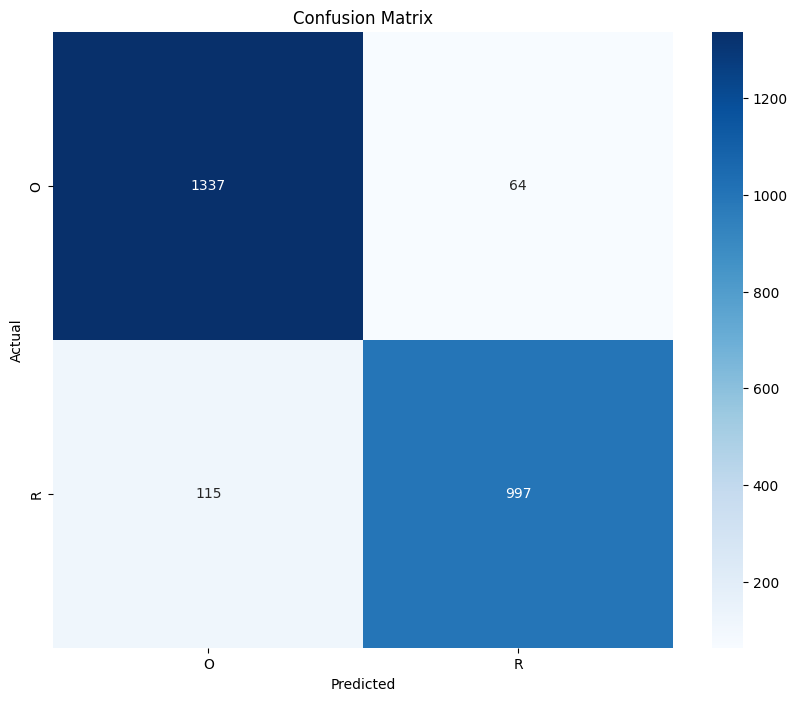

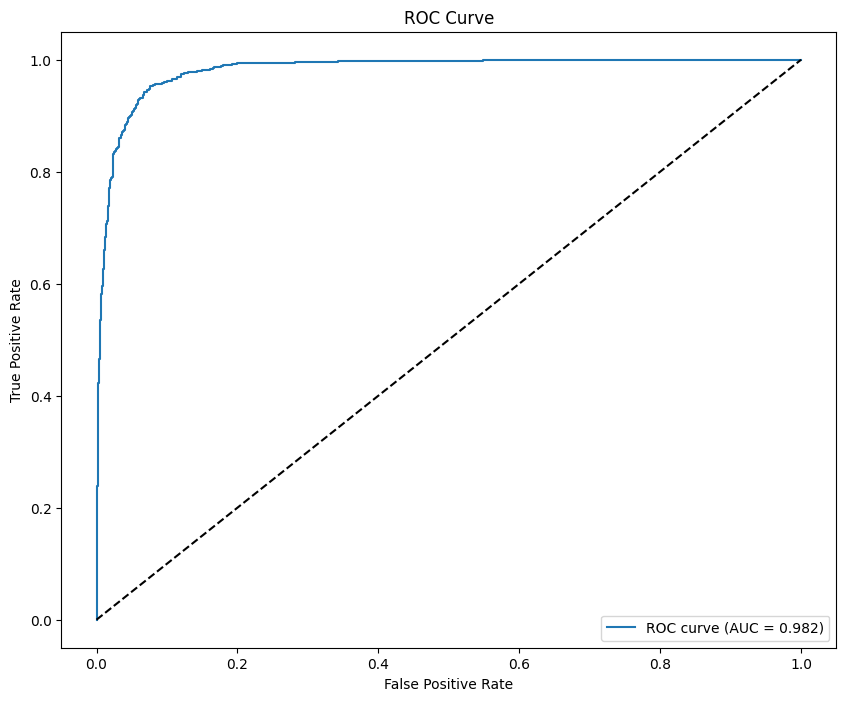

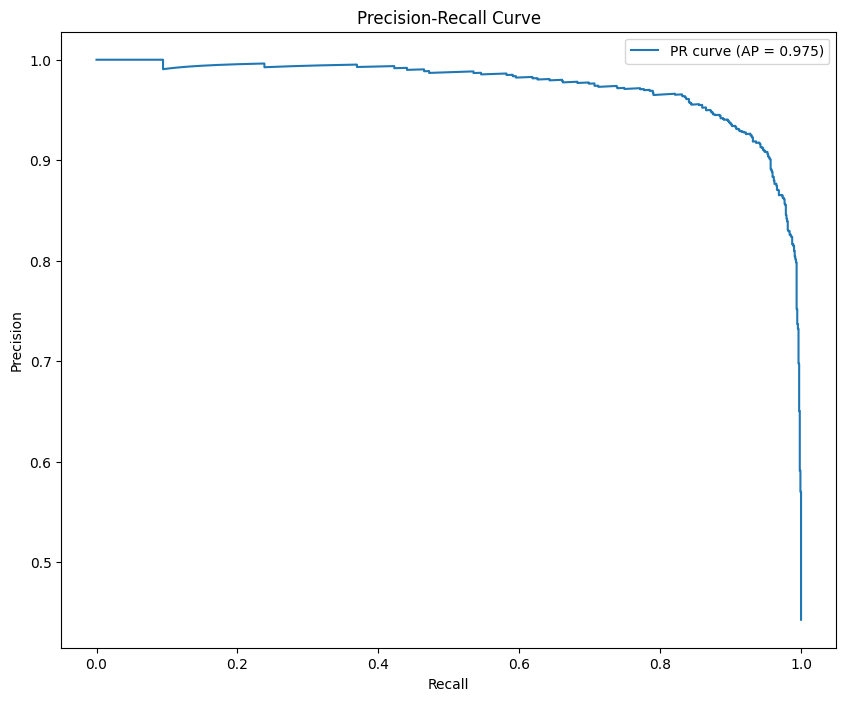

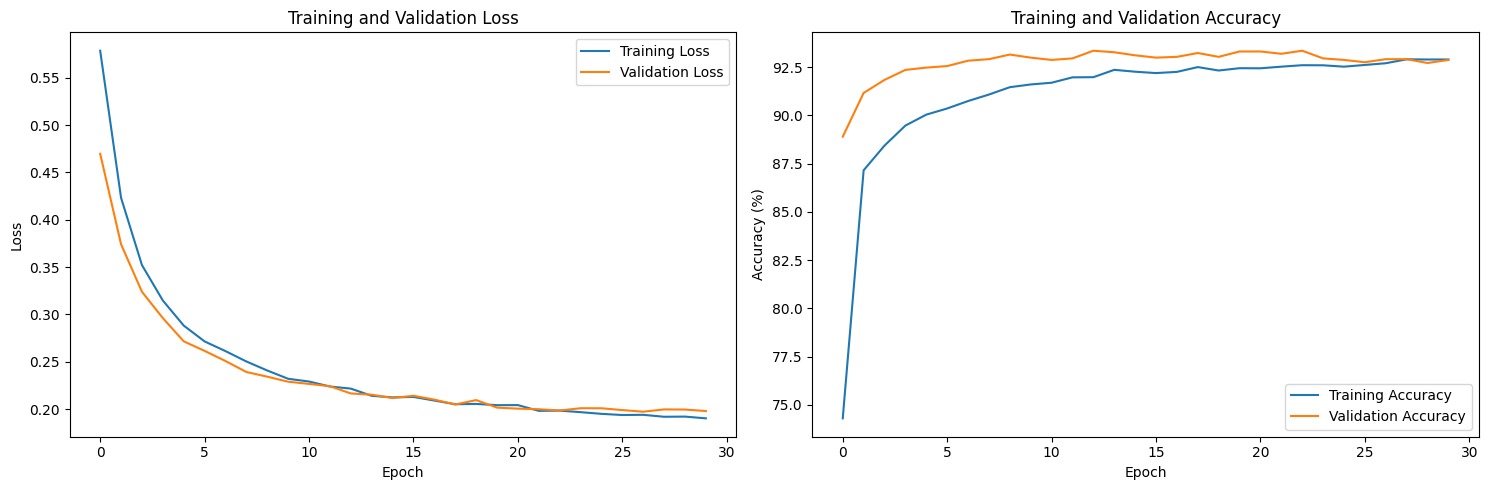


Final Model Performance Summary:
--------------------------------------------------
Best Validation Loss: 0.1973
Final Metrics:
accuracy: 92.8770
precision: 0.9292
recall: 0.9288
f1: 0.9286
auc_roc: 0.9816

Per-class Performance Metrics:
--------------------------------------------------

Class: O
Precision: 0.9208
Recall: 0.9543
F1-Score: 0.9373

Class: R
Precision: 0.9397
Recall: 0.8966
F1-Score: 0.9176
['TRAIN', 'TEST', '.DS_Store']


In [9]:

for epoch in range(num_epochs):
    epoch_start = time()

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, epoch)
    training_history['train_loss'].append(train_loss)
    training_history['train_acc'].append(train_acc)

    # Evaluate
    val_loss, val_preds, val_labels, val_probs = evaluate_model(model, val_loader, criterion)
    training_history['val_loss'].append(val_loss)

    epoch_end = time()
    epoch_duration = epoch_end - epoch_start

    # Calculate metrics
    accuracy = (val_preds == val_labels).mean() * 100
    precision = precision_score(val_labels, val_preds, average='weighted')
    recall = recall_score(val_labels, val_preds, average='weighted')
    f1 = f1_score(val_labels, val_preds, average='weighted')
    auc_roc = roc_auc_score(val_labels, val_probs)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc_roc
    }
    training_history['val_metrics'].append(metrics)

    print(f"\nEpoch {epoch+1} Complete:")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.2f}%")
    print(f"Validation Precision: {precision:.4f}")
    print(f"Validation Recall: {recall:.4f}")
    print(f"Validation F1 Score: {f1:.4f}")
    print(f"Validation AUC-ROC: {auc_roc:.4f}")
    print(f"Epoch duration: {epoch_duration:.2f} seconds")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("New best model saved!")

training_duration = time() - training_start
print(f"\nTraining completed in {training_duration:.2f} seconds")

# Final Evaluation
print("\nFinal Model Evaluation:")
val_loss, final_preds, final_labels, final_probs = evaluate_model(model, val_loader, criterion)

# Print detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(final_labels, final_preds,
                          target_names=train_dataset.classes,
                          digits=4))

# Plot all metrics
plot_metrics(final_labels, final_preds, final_probs, train_dataset.classes)

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(training_history['train_loss'], label='Training Loss')
plt.plot(training_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_history['train_acc'], label='Training Accuracy')
plt.plot([m['accuracy'] for m in training_history['val_metrics']], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Print final summary
print("\nFinal Model Performance Summary:")
print("-" * 50)
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Final Metrics:")
for metric, value in training_history['val_metrics'][-1].items():
    print(f"{metric}: {value:.4f}")

# Calculate per-class metrics
print("\nPer-class Performance Metrics:")
print("-" * 50)
for i, class_name in enumerate(train_dataset.classes):
    class_precision = precision_score(final_labels, final_preds, labels=[i], average=None)[0]
    class_recall = recall_score(final_labels, final_preds, labels=[i], average=None)[0]
    class_f1 = f1_score(final_labels, final_preds, labels=[i], average=None)[0]

    print(f"\nClass: {class_name}")
    print(f"Precision: {class_precision:.4f}")
    print(f"Recall: {class_recall:.4f}")
    print(f"F1-Score: {class_f1:.4f}")

# Save final results to file
with open('training_results.txt', 'w') as f:
    f.write("Waste Classification Model Training Results\n")
    f.write("-" * 50 + "\n")
    f.write(f"Training Duration: {training_duration:.2f} seconds\n")
    f.write(f"Best Validation Loss: {best_val_loss:.4f}\n")
    f.write("\nFinal Classification Report:\n")
    f.write(classification_report(final_labels, final_preds,
                                target_names=train_dataset.classes,
                                digits=4))

import os

print(os.listdir('/content/DATASET'))


In [10]:
#Code

#used from hw1
def rgb_to_gray(image):
    return (0.2125 * image[:,:, 0].astype(np.float32) +
            0.7154 * image[:,:, 1].astype(np.float32) +
            0.0721 * image[:,:, 2].astype(np.float32))

def GaussianBlurImage(image, sigma):
    ## define Gaussian filter
    #got gaussian filter code from filtering.ipynb exactly till convolutio function called
    G_filter_size = 2 * int(4 * sigma + 0.5) + 1
    gaussian_filter = np.zeros((G_filter_size, G_filter_size), np.float32)
    for i in range(G_filter_size):
      for j in range(G_filter_size):
        x = i - G_filter_size // 2
        y = j - G_filter_size // 2
        gaussian_filter[i, j] = 1 / (2 * np.pi * sigma ** 2) * np.exp(-(x ** 2 + y ** 2)/(2 * sigma ** 2))

    ## and convolve
    img_blurred = convolution(image, gaussian_filter) # added filter to function

    return img_blurred

def SobelImage(image):
  #lecture4- Edges: Slide 8
  #formula also found on lec4(slide 8) and  (slide 28,29)
    gx= np.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=np.float32)
    gy = np.array([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=np.float32)
    #pass sobel filters into convolution
    magnitude = np.sqrt((convolution(image, gx)**2) + (convolution(image, gy)**2))
    orientation = np.arctan2(-(convolution(image, gy)), convolution(image, gx)) #arctan2 for angle over all quadrants, negative as per slides
    vertical_edge = convolution(image, gx)
    horizontal_edge = convolution(image, gy)

    return magnitude, orientation, vertical_edge, horizontal_edge

def convolution(image, filter):
    img_convolved = np.zeros_like(image, dtype=np.float32)
    ## if needed, pad image
     ## convolve
     #for boarders, 2D is greyscale and 3D is RBG
    padTwoD = ((filter.shape[0]//2, filter.shape[0]//2), (filter.shape[1]//2, filter.shape[1]//2)) #filtering.ipynb
    padThreeD = ((filter.shape[0]//2, filter.shape[0]//2), (filter.shape[1]//2, filter.shape[1]//2), (0,0))#filtering.ipynb
    imRow = image.shape[0] #from sample_code.py, # of rows
    imCol = image.shape[1]

    match image.ndim: #ndim = dimensions of array : discussion week 2 notebook
      case 3: #3D for color,
        return threedConvole (image, filter, padThreeD, imRow, imCol, img_convolved)

      case 2: #2D for no color
        return greyTwoDConvole (image, filter, padThreeD, imRow, imCol, img_convolved)

def threedConvole (image, filter, padThreeD, imRow, imCol, img_convolved):
  imagePad = ownPad(image,padThreeD, 'constant', 0).astype(np.float32)#filtering.ipynb of pad fucntion created
  for ch in range(image.shape[2]): #3 loops for each R, B, G
    for i in range(imRow):
      for j in range(imCol):
        frame = imagePad[i:i+filter.shape[0], j:j+filter.shape[1], ch] #slicing in discussion week 2 notebook
        img_convolved[i,j,ch] = np.sum(frame * filter)
  return img_convolved

def greyTwoDConvole (image, filter, padTwoD, imRow, imCol, img_convolved):
  imagePad = ownPad(image, padTwoD, 'constant', 0).astype(np.float32)
  for i in range(imRow): # two loops for gray scale
    for j in range(imCol):
      frame = imagePad[i:i+filter.shape[0], j:j+filter.shape[1]] ##slicing in discussion week 2 notebook
      img_convolved [i, j] = np.sum(frame * filter)
  return img_convolved

def ownPad (image, padW, mode, constval):
    #for corners
    leftTop = padW[0][0]
    rightTop = padW[0][1]
    leftBottom = padW[1][0]
    rightBottom = padW[1][1]
    imRow = image.shape[0]
    imCol = image.shape[1]

    # idea to create bigger matrix with zeros and paste the orignal image into center so expand + darker border
    match image.ndim:
      case 2:
        padIm = np.zeros((imRow + leftTop + rightTop, imCol + leftBottom + rightBottom), dtype=image.dtype) #zero matrix
        padIm[leftTop:leftTop+imRow, leftBottom:leftBottom+imCol] = image #orginal image
        return padIm

      case 3:
        padIm = np.zeros((imRow + leftTop + rightTop, imCol + leftBottom + rightBottom, image.shape[2]), dtype=image.dtype) #zero matrix
        padIm[leftTop:leftTop+imRow, leftBottom:leftBottom+imCol, :] = image #orginal image
        return padIm


In [ ]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

def compute_bounding_box_v2(img_rgb,
                            sigma=2.0,
                            edge_thresh=50,
                            min_area_ratio=0.01,
                            border_margin_ratio=0.05):

    img = np.array(img_rgb)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    H, W = gray.shape
    img_area = H * W

    #Gauss Blur
    blur = cv2.GaussianBlur(gray, (5, 5), sigmaX=sigma)

    #Canny edges
    edges = cv2.Canny(blur, edge_thresh, edge_thresh * 2)

    #Contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        print("No contours found.")
        return Image.fromarray(img), None, edges

    # 4) Filter contours
    min_area = min_area_ratio * img_area
    margin_x = int(border_margin_ratio * W)
    margin_y = int(border_margin_ratio * H)

    boxes = []
    for c in contours:
        area = cv2.contourArea(c)
        if area < min_area:
            continue

        x, y, w, h = cv2.boundingRect(c)

        # Get rid of the boxes that highlight the entire image
        if (x <= margin_x and x + w >= W - margin_x and
            y <= margin_y and y + h >= H - margin_y):
            continue

        boxes.append((x, y, w, h))

    if boxes:
        # union all boxes
        xs  = [b[0] for b in boxes]
        ys  = [b[1] for b in boxes]
        x2s = [b[0] + b[2] for b in boxes]
        y2s = [b[1] + b[3] for b in boxes]

        x_min, y_min = min(xs), min(ys)
        x_max, y_max = max(x2s), max(y2s)
        x, y, w, h = x_min, y_min, x_max - x_min, y_max - y_min
        print("Using filtered interior contours.")
    else:
        #Use biggest box
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        print("Using Largest Box")


    img_box = img.copy()
    cv2.rectangle(img_box, (x, y), (x + w, y + h), (255, 0, 0), 3)

    return Image.fromarray(img_box), (int(x), int(y), int(w), int(h)), edges


Num files: 1401
Using test image: /content/DATASET/TEST/O/O_13682.jpg
compute_bounding_box_v2 CALLED
Fallback: using largest contour; box may be large.
Bounding Box: (88, 59, 22, 12)


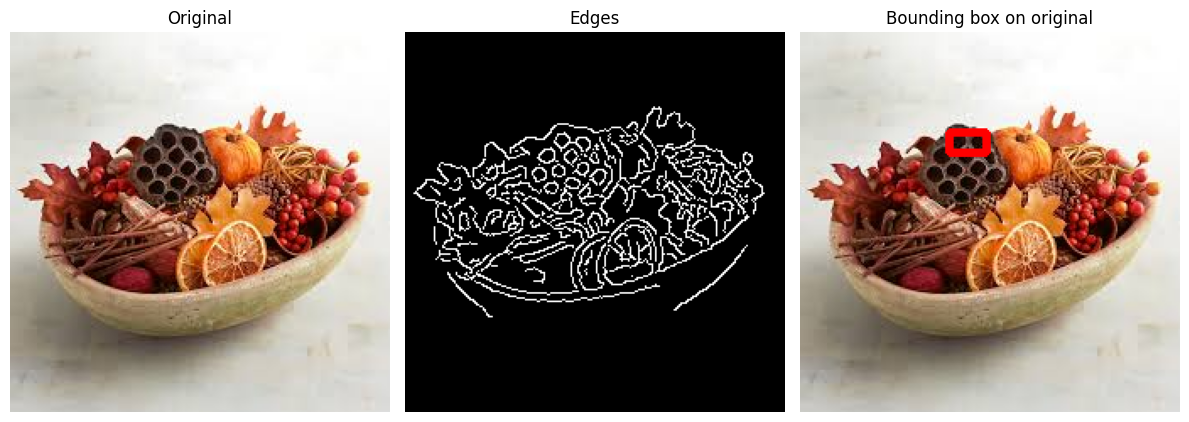

In [12]:
dataSetRoot = "/content/DATASET"

test_folder = os.path.join(dataSetRoot, "TEST", "O")
file_list = [f for f in os.listdir(test_folder) if not f.startswith(".")]
print("Num files:", len(file_list))

test_filename = file_list[6]
test_image_path = os.path.join(test_folder, test_filename)
print("Using test image:", test_image_path)

img = Image.open(test_image_path).convert("RGB")

img_with_box, box, edges = compute_bounding_box_v2(
    img,
    sigma=2.0,
    edge_thresh=50,
    min_area_ratio=0.01,
    border_margin_ratio=0.05
)

print("Bounding Box:", box)

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(img); plt.axis("off")
plt.subplot(1, 3, 2); plt.title("Edges"); plt.imshow(edges, cmap="gray"); plt.axis("off")
plt.subplot(1, 3, 3); plt.title("Bounding box on original"); plt.imshow(img_with_box); plt.axis("off")
plt.tight_layout(); plt.show()


In [13]:
def predict_single_image(model, pil_img):
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    img_tensor = transform(pil_img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        conf, pred_class = torch.max(probs, dim=1)

    class_idx = pred_class.item()
    confidence = conf.item()
    class_name = train_dataset.classes[class_idx]

    return class_name, confidence


In [14]:
#Grab Model
best_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
best_model.classifier[1] = nn.Linear(1280, 2)

best_model.load_state_dict(torch.load('best_model.pth', map_location=device))
best_model.to(device)
best_model.eval()


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [15]:
test_loss, test_preds, test_labels, test_probs = evaluate_model(
    best_model,
    val_loader,
    criterion
)

print("Test loss:", test_loss)

print(classification_report(
    test_labels,
    test_preds,
    target_names=train_dataset.classes,
    digits=4
))



Evaluating model...


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

Test loss: 0.19731987230479717
              precision    recall  f1-score   support

           O     0.9214    0.9543    0.9376      1401
           R     0.9397    0.8975    0.9181      1112

    accuracy                         0.9292      2513
   macro avg     0.9306    0.9259    0.9279      2513
weighted avg     0.9295    0.9292    0.9290      2513



Using test image: /content/food.jpg
compute_bounding_box_v2 CALLED
Fallback: using largest contour; box may be large.
Prediction: O (99.1%)
Bounding Box: (584, 329, 36, 46)


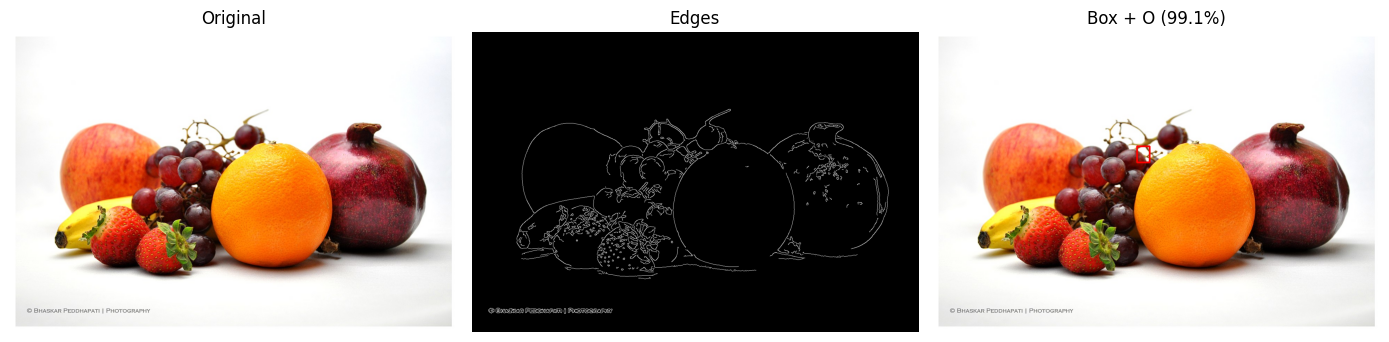

In [27]:
#test with classification + bounding box + confidence on one image

dataSetRoot = "/content/DATASET"
test_folder = os.path.join(dataSetRoot, "TEST", "R")  # or "O"
file_list = [f for f in os.listdir(test_folder) if not f.startswith(".")]
#test_filename = file_list[6]
#test_image_path = os.path.join(test_folder, test_filename)

test_filename = "food.jpg"
test_image_path = "/content/food.jpg"



print("Using test image:", test_image_path)

img = Image.open(test_image_path).convert("RGB")

# Bounding box
img_with_box, box, edges = compute_bounding_box_v2(
    img,
    sigma=2.0,
    min_area_ratio=0.01,
    border_margin_ratio=0.05
)

# Prediction
pred_label, conf = predict_single_image(model, img)

print(f"Prediction: {pred_label} ({conf*100:.1f}%)")
print("Bounding Box:", box)

# Results
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Edges")
plt.imshow(edges, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Box + {pred_label} ({conf*100:.1f}%)")
plt.imshow(img_with_box)
plt.axis("off")

plt.tight_layout()
plt.show()


In [17]:
torch.save(model.state_dict(), "/content/drive/MyDrive/best_model.pth")